# Настройка среды

In [ ]:
%%bash

apt-get update -qq && apt-get install -qq fluidsynth

pip install -qU note-seq pygtrie tensor2tensor pyfluidsynth bokeh==2.4.3
sed -i -e '46,49d' -e '64,67d' /usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/internal/prefer_static.py
sed -i 's/np.bool/bool/g' /usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample_halton_sequence.py
sed -i 's/_kwargs = spec_.kwargs.copy()/_kwargs = spec_.kwargs.copy() if spec_.kwargs else {}/g' /usr/local/lib/python3.10/dist-packages/gym/envs/registration.py

git clone --branch=main https://github.com/magenta/magenta
mv magenta magenta_tmp; mv magenta_tmp/* .; rm -rf magenta_tmp
rm ./magenta/__init__.py
rm ./magenta/models/score2perf/__init__.py

Selecting previously unselected package libqt5core5a:amd64.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../00-libqt5core5a_5.15.3+dfsg-2ubuntu0.2_amd64.deb ...
Unpacking libqt5core5a:amd64 (5.15.3+dfsg-2ubuntu0.2) ...
Selecting previously unselected package libevdev2:amd64.
Preparing to unpack .../01-libevdev2_1.12.1+dfsg-1_amd64.deb ...
Unpacking libevdev2:amd64 (1.12.1+dfsg-1) ...
Selecting previously unselected package libmtdev1:amd64.
Preparing to unpack .../02-libmtdev1_1.1.6-1build4_amd64.deb ...
Unpacking libmtdev1:amd64 (1.1.6-1build4) ...
Selecting previously unselected package libgudev-1.0-0:amd64.
Preparing to unpack .../03-libgudev-1.0-0_1%3a237-2build1_amd64.deb ...
Unpacking libgudev-1.0-0:amd64 (1:237-2build1) ...
Selecting previously unselected package libwacom-common.
Preparing to unpack .../04-libwacom-common_2.2.0-1_all.deb ...
Unpacking libwacom-common (2.2.0-1) ...
Selecting previously unselected package libwacom9:a

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 1.3.8 requires bokeh<3.4.0,>=3.2.0, but you have bokeh 2.4.3 which is incompatible.
Cloning into 'magenta'...


In [ ]:
!gsutil -q -m cp gs://magentadata/soundfonts/Yamaha-C5-Salamander-JNv5.1.sf2 /content/

# Импортирование нужных библиотек

In [ ]:
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from google.colab import files

from tensor2tensor import models
from tensor2tensor import problems
from tensor2tensor.data_generators import text_encoder
from tensor2tensor.utils import decoding
from tensor2tensor.utils import trainer_lib

import note_seq
from magenta.models.score2perf.score2perf import Score2PerfProblem

Instructions for updating:
non-resource variables are not supported in the long term
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (3, 3)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/cor

# Вспомогательные константы и функции

In [ ]:
SF2_PATH = '/content/Yamaha-C5-Salamander-JNv5.1.sf2'
SAMPLE_RATE = 16000

def upload_midi():
    data = list(files.upload().values())
    if len(data) > 1:
        print('Multiple files uploaded; using only one.')
    return note_seq.midi_to_note_sequence(data[0])

def decode(ids):
    ids = list(ids)
    if text_encoder.EOS_ID in ids:
        ids = ids[:ids.index(text_encoder.EOS_ID)]
    return encoder.decode(ids)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def tokens_to_ns(token_ids):
    return note_seq.midi_file_to_note_sequence(decode(token_ids))

In [ ]:
def plot_and_play(ns):
    note_seq.play_sequence(
        ns,
        synth=note_seq.fluidsynth, sample_rate=SAMPLE_RATE, sf2_path=SF2_PATH)
    note_seq.plot_sequence(ns)

In [ ]:
def delete_drums(ns):
    if any(note.is_drum for note in ns.notes):
        print('Note sequence contains drums; they will be removed.')
        notes = [note for note in ns.notes if not note.is_drum]
        del ns.notes[:]
        ns.notes.extend(notes)

In [ ]:
def fix_ns(ns):
    ns = note_seq.apply_sustain_control_changes(ns)
    delete_drums(ns)
    new_notes = sorted([note for note in ns.notes], key=(lambda note: (note.start_time, note.pitch)))
    del ns.notes[:]
    ns.notes.extend(new_notes)
    last_note = {}
    for note in ns.notes:
        note.instrument = 1
        note.program = 0
        if note.pitch in last_note.keys() and last_note[note.pitch].end_time > note.start_time:
            last_note[note.pitch].end_time = note.start_time
        last_note[note.pitch] = note
    return ns

In [ ]:
def ns_prefix(ns, num_notes):
    new_notes = [note for note in ns.notes[:num_notes]]
    del ns.notes[:]
    ns.notes.extend(new_notes)
    ns.total_time = new_notes[-1].end_time

In [ ]:
def decode_to_events(ids):
    ids = list(ids)
    eos_id = text_encoder.EOS_ID
    if eos_id in ids:
        ids = ids[:ids.index(eos_id)]
    performance = note_seq.Performance(
        quantized_sequence=None,
        steps_per_second=100,
        num_velocity_bins=32
    )
    for id in ids:
        performance.append(unconditional_encoders['targets']._encoding.decode_event(id - 2))
    named_events = []
    for event in performance:
        if event.event_type == 1:
            named_event = ('note_on', event.event_value)
        elif event.event_type == 2:
            named_event = ('note_off', event.event_value)
        elif event.event_type == 3:
            named_event = ('time_shift', event.event_value)
        elif event.event_type == 4:
            named_event = ('velocity', 1 + (event.event_value - 1) * 4)
        else:
            named_event = event
        named_events.append(named_event)
    return named_events

# Загрузка модели [Score2Perf Music Transformer](https://colab.research.google.com/notebooks/magenta/piano_transformer/piano_transformer.ipynb)

In [ ]:
model_name = 'transformer'
hparams_set = 'transformer_tpu'
ckpt_path = 'gs://magentadata/models/music_transformer/checkpoints/unconditional_model_16.ckpt'

class PianoPerformanceLanguageModelProblem(Score2PerfProblem):
    @property
    def add_eos_symbol(self):
        return True

problem = PianoPerformanceLanguageModelProblem()
unconditional_encoders = problem.get_feature_encoders()

hparams = trainer_lib.create_hparams(hparams_set=hparams_set)
trainer_lib.add_problem_hparams(hparams, problem)
hparams.num_hidden_layers = 16
hparams.sampling_method = 'random'
hparams.sampling_temp = 1.0

decode_hparams = decoding.decode_hparams()
decode_hparams.alpha = 0.0
decode_hparams.beam_size = 1

run_config = trainer_lib.create_run_config(hparams)
estimator = trainer_lib.create_estimator(
    model_name, hparams, run_config,
    decode_hparams=decode_hparams)

def input_generator():
    global targets
    global decode_length
    while True:
        yield {
            'targets': np.array([targets], dtype=np.int32),
            'decode_length': np.array(decode_length, dtype=np.int32)
        }

targets = []
decode_length = 0

input_fn = decoding.make_input_fn_from_generator(input_generator())
unconditional_samples = estimator.predict(
    input_fn, checkpoint_path=ckpt_path)

_ = next(unconditional_samples)

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
ERROR:tensorfl

In [ ]:
encoder = unconditional_encoders['targets']

In [ ]:
def generate_unconditional(dl=None):
    global targets
    global decode_length
    if dl:
        decode_length = min(dl, 4096 - len(targets))
    else:
        decode_length = max(0, 4096 - len(targets))

    sample_ids = next(unconditional_samples)['outputs']
    return sample_ids

# Определение метрики стилевого различия

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (10, 7)

In [ ]:
feature_names = ['note_density', 'pitch_range', 'mean_pitch', 'var_of_pitch',
                'mean_velocity', 'var_of_velocity', 'mean_duration', 'var_of_duration',
                'start_time_mean_diff', 'var_of_start_time_diff']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def compute_performance_features(ns, start_time, end_time):
    note_list = [note for note in ns.notes if start_time <= note.start_time < end_time]
    note_list = sorted(note_list, key=(lambda note: note.start_time))
    num_notes = len(note_list)
    if num_notes == 0:
        features = [0] * 10
        features[2] = np.mean([note.pitch for note in ns.notes])
        features[6] = 2
        return features
    note_density = num_notes / (end_time - start_time)

    pitch_list = [note.pitch for note in note_list]
    pitch_range = max(pitch_list) - min(pitch_list)

    mean_pitch = np.mean(pitch_list)

    var_of_pitch = np.var(pitch_list)

    velocity_list = [note.velocity for note in note_list]
    mean_velocity = np.mean(velocity_list)

    var_of_velocity = np.var(velocity_list)

    duration_list = [note.end_time - note.start_time for note in note_list]
    mean_duration = np.mean(duration_list)

    var_of_duration = np.var(duration_list)

    start_time_diff = []
    for i in range(1, len(note_list)):
        start_time_diff.append(note_list[i].start_time - note_list[i - 1].start_time)

    if len(start_time_diff) > 0:
        start_time_mean_diff = np.mean(start_time_diff)
        var_of_start_time_diff = np.var(start_time_diff)
    else:
        start_time_mean_diff, var_of_start_time_diff = 0, 0

    features = [note_density, pitch_range, mean_pitch, var_of_pitch,
                mean_velocity, var_of_velocity, mean_duration, var_of_duration,
                start_time_mean_diff, var_of_start_time_diff]
    return features

In [ ]:
def style_difference(ns_1, ns_2, window_size=2, functions={}, epsilons={}, weights=np.ones(10), plot=None):
    if ns_1.total_time < ns_2.total_time:
        max_time = ns_1.total_time
        ns_2 = note_seq.extract_subsequence(ns_2, 0, max_time)
    else:
        max_time = ns_2.total_time
        ns_1 = note_seq.extract_subsequence(ns_1, 0, max_time)
    features_1, features_2 = [], []
    for start_time in np.arange(0, max_time, window_size):
        if start_time + window_size > max_time:
            start_time = max_time - window_size
        features_1.append(compute_performance_features(ns_1, start_time, start_time + window_size))
        features_2.append(compute_performance_features(ns_2, start_time, start_time + window_size))
    features_1 = np.array(features_1)
    features_2 = np.array(features_2)
    error_matrix = np.zeros(features_1.shape)
    for i in range(len(feature_names)):
        f = functions[feature_names[i]]
        eps = epsilons[feature_names[i]]
        error_matrix[:,i] = f(features_1[:,i], features_2[:,i], eps) / weights[i]
    error_matrix[:,[2,4,5]] = 0
    if plot:
        time_axis = np.arange(0, max_time, window_size)
        if plot == 'metric':
            plt.plot(time_axis, error_matrix.mean(1), color='blue')
            plt.ylabel('Значение метрики')
        elif plot == 'all_features':
            for i, name in enumerate(feature_names):
                plt.plot(time_axis, error_matrix[:, i], label=name)
            plt.ylabel('Значение функций потерь')
            plt.legend()
        else:
            idx = feature_names.index(plot)
            plt.plot(time_axis, features_1[:,idx], label='Трек 1')
            plt.plot(time_axis, features_2[:,idx], label='Трек 2')
            plt.ylabel(f'Значение признака {plot}')
            plt.legend()
        plt.xlabel('Время, с')
        plt.show()
    return error_matrix.mean()

In [ ]:
def abs_log_error(f1, f2, eps):
    return np.abs(np.log(f1 + eps) - np.log(f2 + eps))

def abs_error(f1, f2, eps=0):
    return np.abs(f1 - f2)

functions = {name: abs_log_error for name in feature_names}
functions['mean_pitch'] = abs_error

In [ ]:
feature_eps = {name: 1 for name in feature_names}
feature_eps['mean_pitch'] = feature_eps['mean_duration'] = 0
feature_eps['var_of_duration'] = feature_eps['start_time_mean_diff'] = \
        feature_eps['var_of_start_time_diff'] = 0.01

In [ ]:
weights = np.array([0.72521614, 0.69565941, 9.66134072, 1.20305637, 0.42238247,
       1.06960022, 1.05404574, 1.30573771, 0.68013447, 0.71436818])

# Загрузка MIDI-файлов классический произведений

In [ ]:
import gdown

In [ ]:
gdown.download(
    'https://drive.google.com/uc?id=1ohEAGCToOqI00wZgrLKb1djGJbvVsP3W',
    'classical_pieces.zip',
    quiet=False
)

Downloading...
From: https://drive.google.com/uc?id=1ohEAGCToOqI00wZgrLKb1djGJbvVsP3W
To: /content/classical_pieces.zip
100%|██████████| 51.8k/51.8k [00:00<00:00, 42.5MB/s]


'classical_pieces.zip'

In [ ]:
%%bash

mkdir classical_pieces
unzip classical_pieces.zip -d classical_pieces

Archive:  classical_pieces.zip
 extracting: classical_pieces/nocturne_op_9_1.mid  
 extracting: classical_pieces/turkish_march.mid  
 extracting: classical_pieces/moonlight_sonata.mid  
 extracting: classical_pieces/gymnopedie_1.mid  
 extracting: classical_pieces/fur_elise.mid  


In [ ]:
fe_ns = note_seq.midi_file_to_note_sequence('./classical_pieces/fur_elise.mid')
fe_ns = note_seq.extract_subsequence(fe_ns, 0, 27)
fe_ns = fix_ns(fe_ns)
plot_and_play(fe_ns)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tm_ns = note_seq.midi_file_to_note_sequence('./classical_pieces/turkish_march.mid')
tm_ns = fix_ns(tm_ns)
plot_and_play(tm_ns)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
plot_and_play(note_seq.extract_subsequence(tm_ns, 0, 27))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


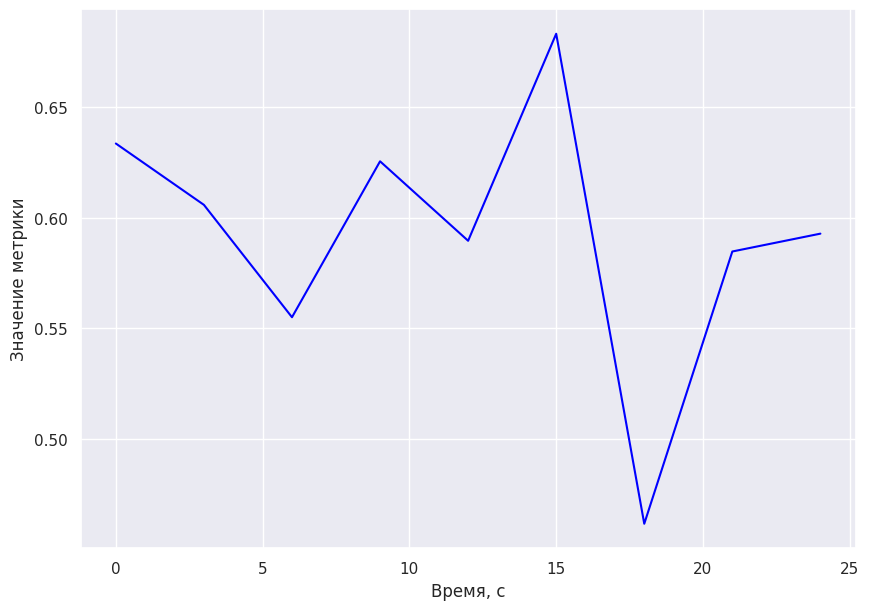

0.592480873020755

In [ ]:
style_difference(fe_ns, tm_ns, 3, functions, feature_eps, weights, plot='metric')

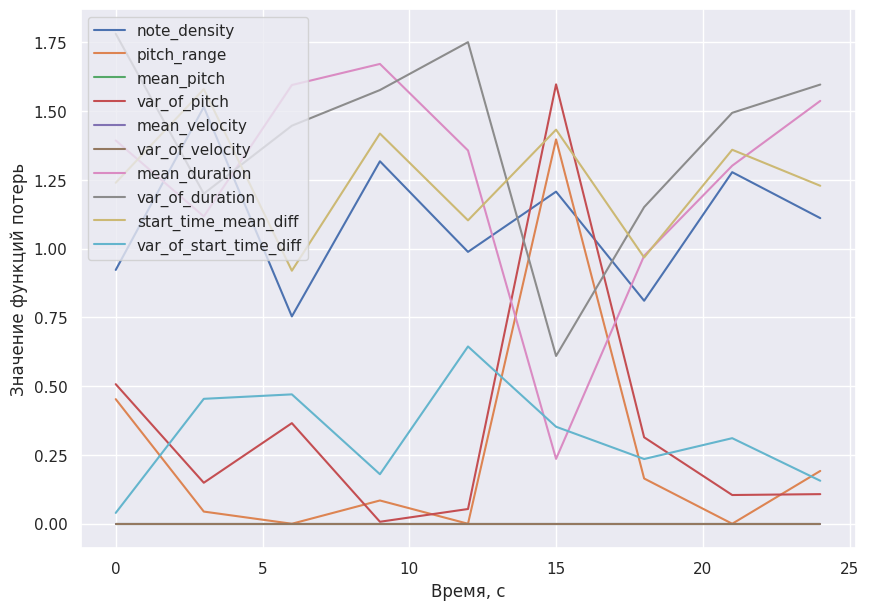

0.592480873020755

In [ ]:
style_difference(fe_ns, tm_ns, 3, functions, feature_eps, weights, plot='all_features')

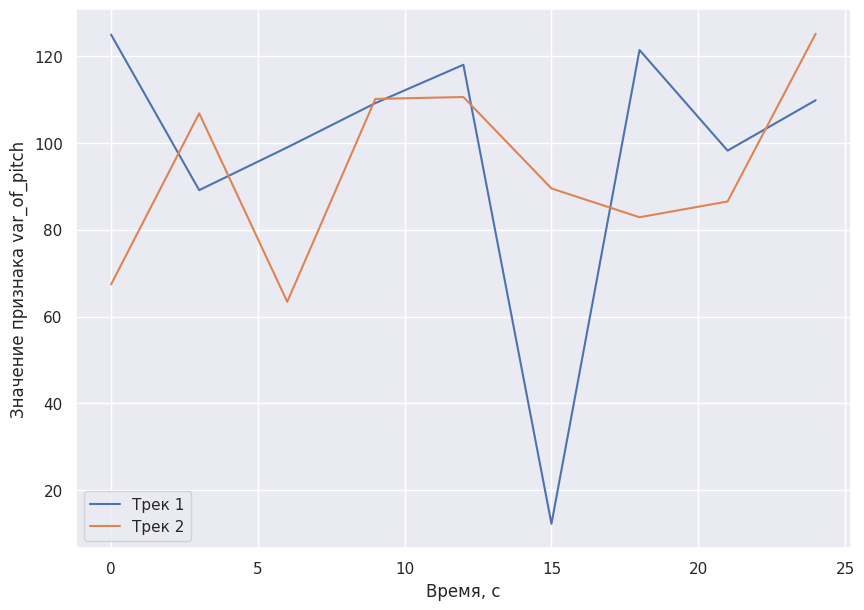

0.592480873020755

In [ ]:
style_difference(fe_ns, tm_ns, 3, functions, feature_eps, weights, plot='var_of_pitch')

# Качественный эксперимент по валидации метрики стилевого различия

## Чтобы загрузить оригинальные результаты эксперимента, запустите эти ячейки.

In [ ]:
gdown.download(
    'https://drive.google.com/uc?id=1LG-PSC0fm1q3J2-Ugc_-R2ooK9x54plk',
    'metric_validation_samples.zip',
    quiet=False
)

Downloading...
From: https://drive.google.com/uc?id=1LG-PSC0fm1q3J2-Ugc_-R2ooK9x54plk
To: /content/metric_validation_samples.zip
100%|██████████| 7.70k/7.70k [00:00<00:00, 9.80MB/s]


'metric_validation_samples.zip'

In [ ]:
%%bash

mkdir metric_validation_samples
unzip metric_validation_samples.zip -d metric_validation_samples

Archive:  metric_validation_samples.zip
 extracting: metric_validation_samples/metric_validation_sample_4.mid  
 extracting: metric_validation_samples/metric_validation_sample_17.mid  
 extracting: metric_validation_samples/metric_validation_sample_3.mid  
 extracting: metric_validation_samples/metric_validation_sample_14.mid  
 extracting: metric_validation_samples/metric_validation_sample_6.mid  
 extracting: metric_validation_samples/metric_validation_sample_10.mid  
 extracting: metric_validation_samples/metric_validation_sample_19.mid  
 extracting: metric_validation_samples/metric_validation_sample_9.mid  
 extracting: metric_validation_samples/metric_validation_sample_11.mid  
 extracting: metric_validation_samples/metric_validation_sample_1.mid  
 extracting: metric_validation_samples/metric_validation_sample_2.mid  
 extracting: metric_validation_samples/metric_validation_sample_15.mid  
 extracting: metric_validation_samples/metric_validation_sample_0.mid  
 extracting: metri

In [ ]:
import os

def get_midi_files(directory):
    return [file for file in os.listdir(directory) if file.endswith('.mid')]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dataset_dir = './metric_validation_samples'

midi_files = get_midi_files(dataset_dir)
midi_files_paths = [os.path.join(dataset_dir, file) for file in midi_files]

In [ ]:
nss = [note_seq.midi_file_to_note_sequence(path) for path in midi_files_paths]
errors = []
for ns in nss:
    errors.append(style_difference(ns, fe_ns, 3, functions, feature_eps, weights))

## Чтобы запустить эксперимент заново, раскомментируйте и запустите эту ячейку (возможны немного другие результаты).

In [ ]:
# targets = encoder.encode_note_sequence(fe_ns)[:22]

# for i in range(1):
#     print('Step', i + 1)
#     candidates = []
#     for j in range(20):
#         sample_ids = generate_unconditional(100)
#         candidates.append(list(targets) + list(sample_ids))
#     nss = [note_seq.midi_file_to_note_sequence(decode(ids)) for ids in candidates]
#     errors = []
#     for ns in nss:
#         errors.append(style_difference(ns, fe_ns, 3, functions, feature_eps, weights))
#     idx = np.argmin(errors)
#     targets = candidates[idx]
#     if targets[-1] == 1:
#         targets = targets[:-1]
# new_ns = note_seq.midi_file_to_note_sequence(decode(targets))
# plot_and_play(new_ns)

## Определение метрики мелодического различия

In [ ]:
def levenshtein(str_1, str_2):
    n, m = len(str_1), len(str_2)
    if n > m:
        str_1, str_2 = str_2, str_1
        n, m = m, n

    current_row = range(n + 1)
    for i in range(1, m + 1):
        previous_row, current_row = current_row, [i] + [0] * n
        for j in range(1, n + 1):
            add, delete, change = previous_row[j] + 1, current_row[j - 1] + 1, previous_row[j - 1]
            if str_1[j - 1] != str_2[i - 1]:
                change += 1
            current_row[j] = min(add, delete, change)

    return current_row[n]

In [ ]:
def get_pitch_list(ns):
    return [note.pitch for note in sorted(ns.notes, key=(lambda n: (n.start_time, n.pitch)))]

In [ ]:
def music_levenshtein(ns_1, ns_2):
    pitches_1 = get_pitch_list(ns_1)
    pitches_2 = get_pitch_list(ns_2)
    min_len = min(len(pitches_1), len(pitches_2))
    pitches_1 = pitches_1[:min_len]
    pitches_2 = pitches_2[:min_len]
    return levenshtein(pitches_1, pitches_2) / min_len

In [ ]:
lev_metric_values = [music_levenshtein(fe_ns, ns) for ns in nss]

## Результаты эксперимента

In [ ]:
plot_and_play(fe_ns)

In [ ]:
primer_ns = tokens_to_ns(encoder.encode_note_sequence(fe_ns)[:22])
plot_and_play(primer_ns)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for step, i in enumerate(np.argsort(errors)):
    print('----------------------')
    print('Sample', step + 1)
    print('Style difference:', errors[i])
    print('Normalized Levenshtein distance:', lev_metric_values[i])
    plot_and_play(nss[i])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


----------------------
Sample 1
Style difference: 0.053044628905538446
Normalized Levenshtein distance: 0.0


----------------------
Sample 2
Style difference: 0.14307797021576715
Normalized Levenshtein distance: 0.030303030303030304


----------------------
Sample 3
Style difference: 0.23034971841363
Normalized Levenshtein distance: 0.3103448275862069


----------------------
Sample 4
Style difference: 0.23724046772666021
Normalized Levenshtein distance: 0.6363636363636364


----------------------
Sample 5
Style difference: 0.27332426734011184
Normalized Levenshtein distance: 0.5454545454545454


----------------------
Sample 6
Style difference: 0.34236802680086403
Normalized Levenshtein distance: 0.53125


----------------------
Sample 7
Style difference: 0.35910705918807834
Normalized Levenshtein distance: 0.42424242424242425


----------------------
Sample 8
Style difference: 0.3745818390381525
Normalized Levenshtein distance: 0.696969696969697


----------------------
Sample 9
Style difference: 0.39843163447577346
Normalized Levenshtein distance: 0.7575757575757576


----------------------
Sample 10
Style difference: 0.42999393163371663
Normalized Levenshtein distance: 0.5


----------------------
Sample 11
Style difference: 0.44207369077645636
Normalized Levenshtein distance: 0.4827586206896552


----------------------
Sample 12
Style difference: 0.453051560907663
Normalized Levenshtein distance: 0.5806451612903226


----------------------
Sample 13
Style difference: 0.46585189662734233
Normalized Levenshtein distance: 0.41935483870967744


----------------------
Sample 14
Style difference: 0.5403670136178095
Normalized Levenshtein distance: 0.7666666666666667


----------------------
Sample 15
Style difference: 0.5660332427293746
Normalized Levenshtein distance: 0.25


----------------------
Sample 16
Style difference: 0.6178238682498105
Normalized Levenshtein distance: 0.7352941176470589


----------------------
Sample 17
Style difference: 0.8595445209928608
Normalized Levenshtein distance: 0.6785714285714286


----------------------
Sample 18
Style difference: 0.9344876098891935
Normalized Levenshtein distance: 0.7037037037037037


----------------------
Sample 19
Style difference: 0.9471504753144022
Normalized Levenshtein distance: 0.7407407407407407


----------------------
Sample 20
Style difference: 1.1294110501639378
Normalized Levenshtein distance: 0.6875


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


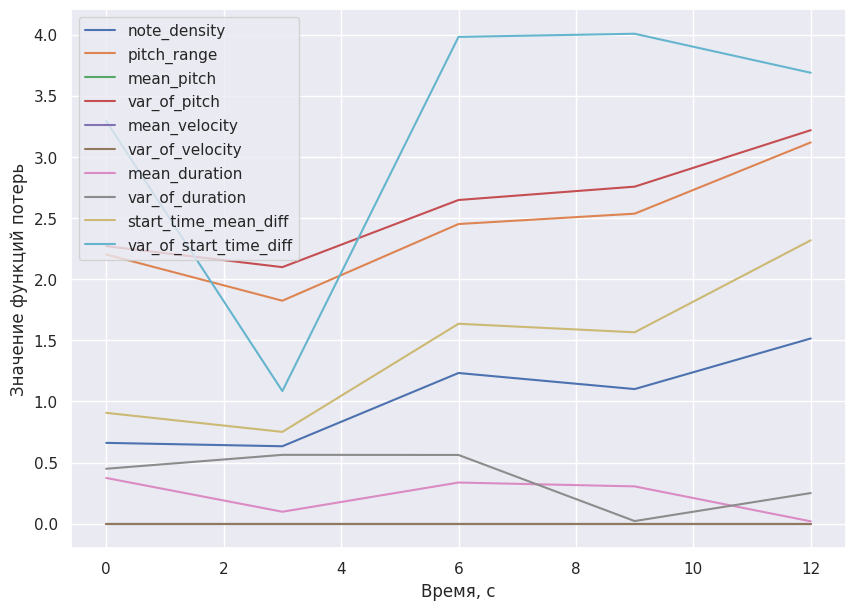

1.1294110501639378

In [ ]:
style_difference(fe_ns, nss[np.argsort(errors)[-1]], 3, functions, feature_eps, weights, plot='all_features')

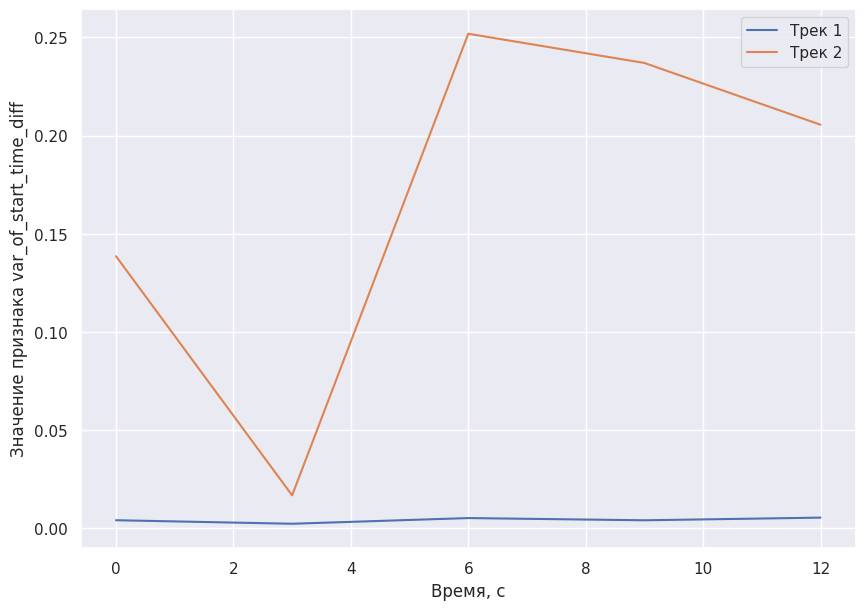

1.1294110501639378

In [ ]:
style_difference(fe_ns, nss[np.argsort(errors)[-1]], 3, functions, feature_eps, weights, plot='var_of_start_time_diff')

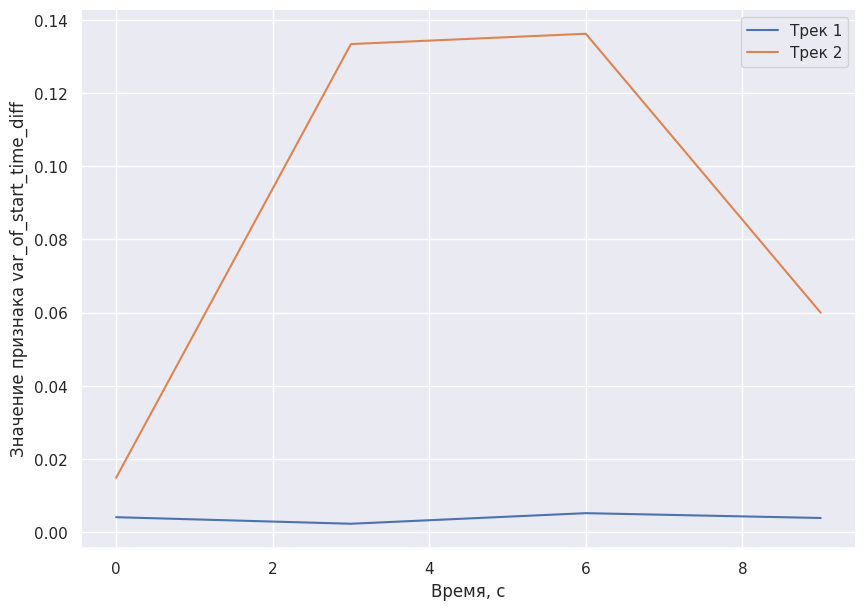

0.6178238682498105

In [ ]:
style_difference(fe_ns, nss[np.argsort(errors)[15]], 3, functions, feature_eps, weights, plot='var_of_start_time_diff')

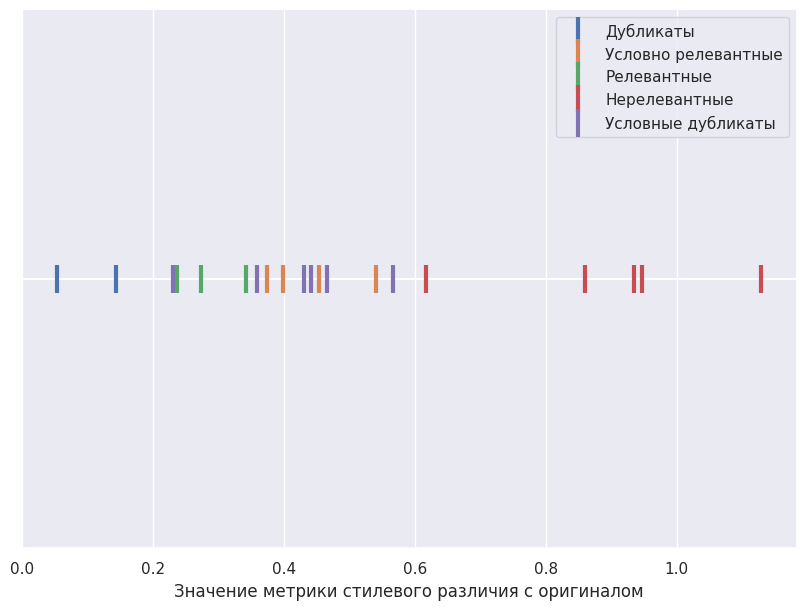

In [ ]:
idxs = np.argsort(errors)
sorted_errors = np.array(errors)[idxs]
clusters = {'Дубликаты': [0, 1], 'Условно релевантные': [7, 8, 11, 13], 'Релевантные': [3, 4, 5],
              'Нерелевантные': [15, 16, 17, 18, 19], 'Условные дубликаты': [2, 6, 9, 10, 12, 14]}
plt.axhline(y=0, color='white')
for label, positions in clusters.items():
    plt.plot(sorted_errors[positions], [0] * len(sorted_errors[positions]), '|', label=label,
             markersize=20, markeredgewidth=3)
plt.yticks([])
plt.xlabel('Значение метрики стилевого различия с оригиналом')
plt.legend()
plt.show()

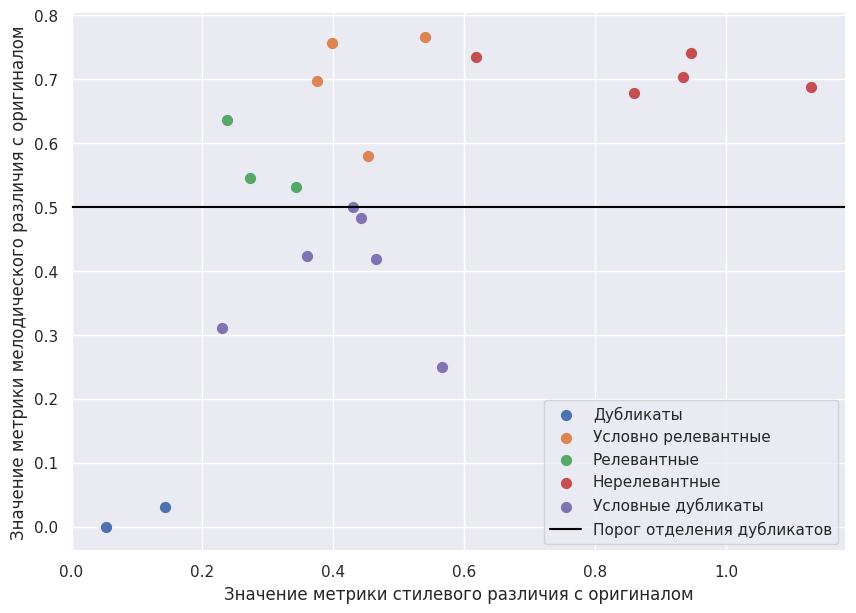

In [ ]:
sorted_lev = np.array(lev_metric_values)[idxs]
for label, positions in clusters.items():
    plt.scatter(sorted_errors[positions], sorted_lev[positions], label=label, s=50)
plt.axhline(y=0.5, color='black', label='Порог отделения дубликатов')
plt.xlabel('Значение метрики стилевого различия с оригиналом')
plt.ylabel('Значение метрики мелодического различия с оригиналом')
plt.legend()
plt.show()

# Стилевое распределение сэмплов Music Transformer

In [ ]:
dataset_dir = './classical_pieces'

midi_files = get_midi_files(dataset_dir)
midi_files_paths = [os.path.join(dataset_dir, file) for file in midi_files]

In [ ]:
import pandas as pd

def create_score_df():
    df = pd.DataFrame(data={
        'file_id': file_ids,
        'file_name': file_names,
        'primer_size': primer_sizes,
        'full_style_difference': full_style_differences,
        'full_levenshtein': full_levenshteins,
        'generated_style_difference': generated_style_differences,
        'generated_levenshtein': generated_levenshteins
    })
    return df

In [ ]:
from tqdm import tqdm

In [ ]:
file_ids = []
file_names = []
primer_sizes = []
full_style_differences = []
full_levenshteins = []
generated_style_differences = []
generated_levenshteins = []
generated_nss = []

for file_id in range(len(midi_files)):
    file_name = midi_files[file_id]
    file_path = midi_files_paths[file_id]
    file_ns = note_seq.midi_file_to_note_sequence(file_path)
    fix_ns(file_ns)
    file_perf_ids = encoder.encode_note_sequence(file_ns)
    print(f'Processing file {file_id + 1}')
    for primer_size in tqdm(range(101)):
        targets = file_perf_ids[:primer_size]
        primer_time = tokens_to_ns(targets).total_time
        if primer_time + 5 > file_ns.total_time:
            break
        sample_ids = generate_unconditional(100)
        sample_ids = list(targets) + list(sample_ids)
        sample_ns = note_seq.midi_file_to_note_sequence(decode(sample_ids))
        full_style_difference = style_difference(file_ns, sample_ns, 3, functions, feature_eps, weights)
        full_levenshtein = music_levenshtein(file_ns, sample_ns)

        ns_generated = note_seq.extract_subsequence(sample_ns, primer_time, primer_time + 60)
        generated_time = ns_generated.total_time
        file_ns_cropped = note_seq.extract_subsequence(file_ns, primer_time, primer_time + generated_time)
        generated_style_difference = style_difference(
            file_ns_cropped, ns_generated, 3, functions, feature_eps, weights
        )
        generated_levenshtein = music_levenshtein(file_ns_cropped, ns_generated)

        file_ids.append(file_id)
        file_names.append(file_name)
        primer_sizes.append(primer_size)
        full_style_differences.append(full_style_difference)
        full_levenshteins.append(full_levenshtein)
        generated_style_differences.append(generated_style_difference)
        generated_levenshteins.append(generated_levenshtein)

        generated_nss.append(sample_ns)
    df = create_score_df()
    df.to_csv('scores.csv', index=False)

Processing file 1


100%|██████████| 101/101 [09:36<00:00,  5.71s/it]


Processing file 2


100%|██████████| 101/101 [09:11<00:00,  5.46s/it]


Processing file 3


100%|██████████| 101/101 [09:14<00:00,  5.49s/it]
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Processing file 4


100%|██████████| 101/101 [09:17<00:00,  5.52s/it]


Processing file 5


100%|██████████| 101/101 [09:10<00:00,  5.45s/it]


In [ ]:
# file_list = []
# for i, ns in enumerate(generated_nss):
#     filename = f'sample_{i}.mid'
#     note_seq.sequence_proto_to_midi_file(
#         ns, filename
#     )
#     file_list.append(filename)

In [ ]:
# import zipfile

# def create_zip(file_paths, zip_name):
#     with zipfile.ZipFile(zip_name, 'w') as zipf:
#         for file_path in file_paths:
#             zipf.write(file_path, os.path.basename(file_path))

In [ ]:
# create_zip(file_list, 'classical_samples.zip')

In [ ]:
df = df[df.primer_size != 100].copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
same_melody = df.full_levenshtein <= 0.5
relevant = df.full_style_difference < 0.32
partially_relevant = (0.32 <= df.full_style_difference) & (df.full_style_difference < 0.52)

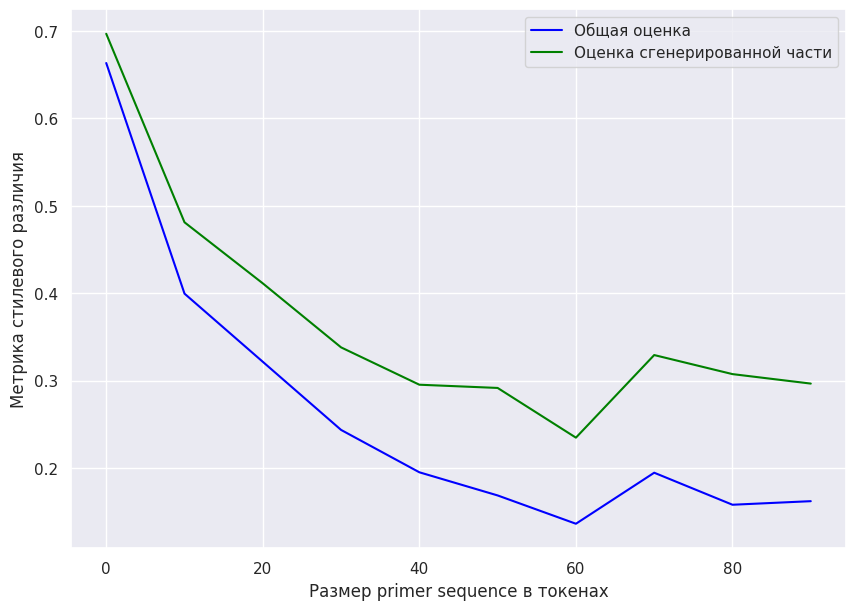

In [ ]:
df['primer_bin'] = df.primer_size // 10 * 10
df.groupby('primer_bin').full_style_difference.mean().plot(color='blue', label='Общая оценка')
df.groupby('primer_bin').generated_style_difference.mean().plot(color='green', label='Оценка сгенерированной части')
plt.legend()
plt.xlabel('Размер primer sequence в токенах')
plt.ylabel('Метрика стилевого различия')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


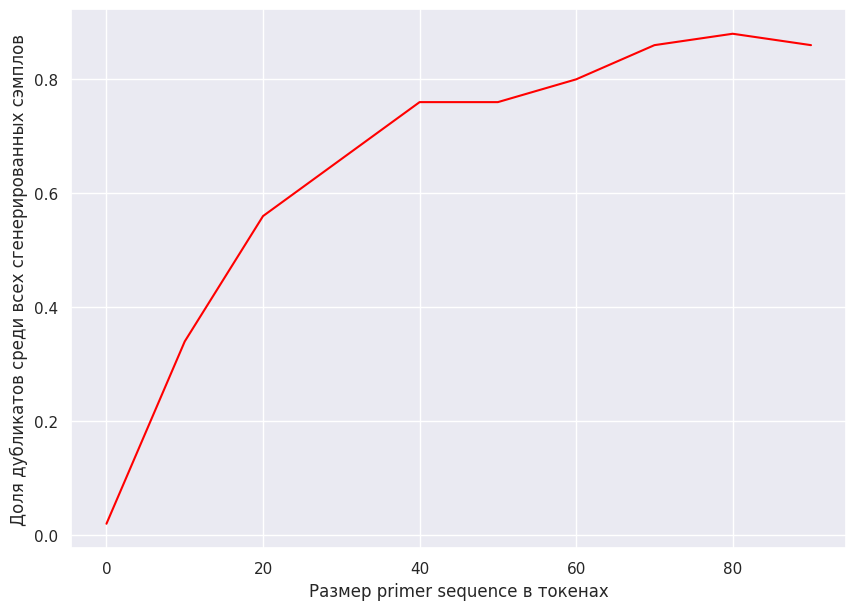

In [ ]:
(df[same_melody].groupby('primer_bin').size() / df.groupby('primer_bin').size()).plot(color='red')
plt.xlabel('Размер primer sequence в токенах')
plt.ylabel('Доля дубликатов среди всех сгенерированных сэмплов')
plt.show()

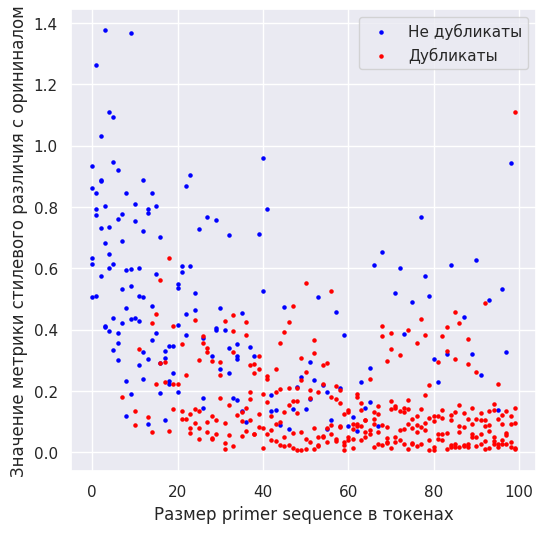

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(df[~same_melody].primer_size, df[~same_melody].full_style_difference, color='blue', s=5,
            label='Не дубликаты')
plt.scatter(df[same_melody].primer_size, df[same_melody].full_style_difference, color='red', s=5,
            label='Дубликаты')
plt.legend()
plt.xlabel('Размер primer sequence в токенах')
plt.ylabel('Значение метрики стилевого различия с орининалом')
plt.show()

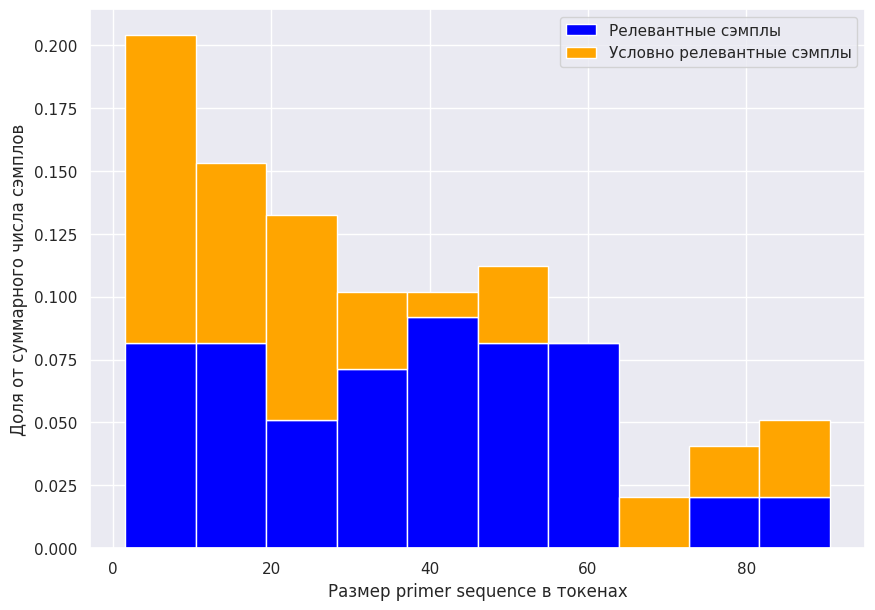

In [ ]:
hist1, bins = np.histogram(df[(~same_melody) & relevant].primer_size, bins=10)
hist2, _ = np.histogram(df[(~same_melody) & partially_relevant].primer_size, bins=bins)
num_samples = hist1.sum() + hist2.sum()
hist1, hist2 = hist1 / num_samples, hist2 / num_samples
plt.bar(bins[:-1], hist1, color='blue', width=np.diff(bins), label='Релевантные сэмплы')
plt.bar(bins[:-1], hist2, color='orange', width=np.diff(bins), bottom=hist1, label='Условно релевантные сэмплы')
plt.legend()
plt.xlabel('Размер primer sequence в токенах')
plt.ylabel('Доля от суммарного числа сэмплов')
plt.show()

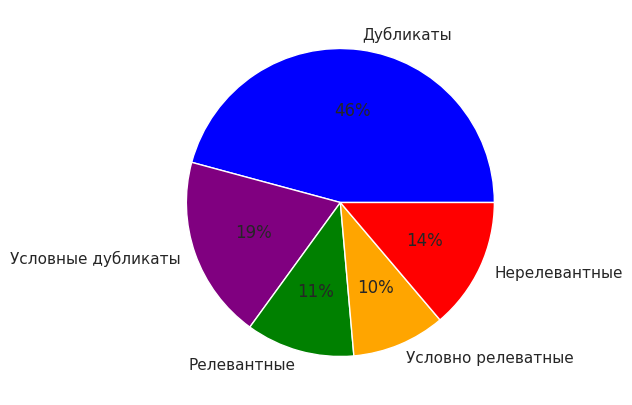

In [ ]:
plt.figure(figsize=(5, 5))
dups = len(df[same_melody & (df.full_style_difference < 0.17)])
part_dups = len(df[same_melody & (df.full_style_difference >= 0.17)])
rel = len(df[(~same_melody) & relevant])
part_rel = len(df[(~same_melody) & partially_relevant])
irrel = len(df[(~same_melody) & (~relevant) & (~partially_relevant)])

labels = ['Дубликаты', 'Условные дубликаты', 'Релевантные', 'Условно релеватные',
          'Нерелевантные']
sizes = [dups, part_dups, rel, part_rel, irrel]
colors = ['blue', 'purple', 'green', 'orange', 'red']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%')
plt.show()